In [91]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sop
import pyute as ut

/home/mossing/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [104]:
t.shape

(10000,)

In [251]:
# the approach here is to numerically simulate as a function of light intensity and time
# the fraction of a population of ion channels that are open, based on first order kinetics, 
# and to use that as the input to a conductance based neuron model with some fixed leak conductance. 
# The result will be a simulated depolarization PSF, in mV, as a function of offset from the
# target center in z.
dt = 0.05 # granularity of the simulation in ms; this should be small
tmax = 1500-dt # number of ms to simulate
t = np.linspace(0,tmax,tmax/dt+1)
Nt = t.size
dintensity = 5 # granularity of light intensities to simulate; this should be small
intensitymax = 50 # maximum RMS intensity to test, in units of 1/sqrt(opsin two photon action cross section* opsin tau off)
intensity = np.linspace(0,intensitymax,intensitymax/dintensity+1)
Ni = intensity.size
tauoff = 100 # (opsin tau off in ms)
tauinact = 100 # (opsin inactivation time const in ms)
taureact = 1000 # (opsin return to ground state time const in ms)

Copen = np.zeros((Nt,Ni)) # vector of the fraction open channels over time and intensity
Cinactive = np.zeros((Nt,Ni)) # vector of the fraction open channels over time and intensity
V = Vrest*np.ones((Nt,Ni)) # vector of cell membrane voltage over time and intensity, in mV
koff = 1/tauoff
kinact = 1/tauinact
kreact = 1/taureact

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


In [252]:
tpulse = 500

In [253]:
# # closed <-> open -> inactive -> closed 
# def model_C(koff,kinact,kreact):
#     Copen = np.zeros((Nt,Ni)) # vector of the fraction open channels over time and intensity
#     Cinactive = np.zeros((Nt,Ni)) # vector of the fraction open channels over time and intensity
#     for i,time in enumerate(t[:-1]):
#         # first order kinetics a two-state model and two photon absorption
#         Cclosed = 1-Copen[i]-Cinactive[i]
#         if time < tpulse:
#             Copen[i+1] = Copen[i] + dt*intensity**2*Cclosed - dt*koff*Copen[i] - dt*kinact*Copen[i]
#         else:
#             Copen[i+1] = Copen[i] - dt*koff*Copen[i] - dt*kinact*Copen[i]
#         Cinactive[i+1] = Cinactive[i] + dt*kinact*Copen[i] - dt*kreact*Cinactive[i]
#     return Copen

In [254]:
def cost_function(Imax,koff,kinact,kreact,intensity0):
    Copen = model_C(koff,kinact,kreact,intensity0)
    Ipred = Imax*Copen
    return ((Imeas-Ipred)**2).sum()

In [255]:
def off_by_function(Imax,koff,kinact,kreact,intensity0):
    Copen = model_C(koff,kinact,kreact,intensity0)
    Ipred = Imax*Copen
    return (Imeas-Ipred).flatten()

In [256]:
def cost_function_compressed(params):
    return cost_function(*params)

In [257]:
def off_by_function_compressed(params):
    return off_by_function(*params)

In [258]:
Imeas = ut.loadmat('cleaned_gtacr_data.mat','mean_traces')[:,10000:40000].T
intensity = ut.loadmat('cleaned_gtacr_data.mat','upower')
Nt = Imeas.shape[0]
Ni = intensity.size

In [259]:
intensity

array([  0,   5,  10,  25,  50,  75, 100], dtype=uint8)

In [260]:
tpulse

500

In [366]:
# closed <-> open -> inactive -> closed 
def model_C(koff,kinact,kreact,intensity0):
    Copen = np.zeros((Nt,Ni)) # vector of the fraction open channels over time and intensity
    Cinactive = 0 # vector of the fraction open channels over time and intensity
    for i,time in enumerate(t[:-1]):
        # first order kinetics a two-state model and two photon absorption
        Cclosed = 1-Copen[i]-Cinactive
        if time < tpulse:
            Copen[i+1] = Copen[i] + dt*(intensity/intensity0)**2*Cclosed - dt*koff*Copen[i] - dt*kinact*Copen[i]
        else:
            Copen[i+1] = Copen[i] - dt*koff*Copen[i] - dt*kinact*Copen[i]
        Cinactive = Cinactive + dt*kinact*Copen[i] - dt*kreact*Cinactive
    return Copen

In [367]:
Imeas.shape

(30000, 7)

In [368]:
intensity0 = 40
Imax = 100
SNR = 1e3
# Imeas = Imax*model_C(koff,kinact,kreact,intensity0)
# Imeas = Imeas + Imax*np.random.randn(Imeas.shape[0],Imeas.shape[1])/SNR

In [369]:
intensity0

40

In [370]:
koff_guess = 0.01
kinact_guess = 0.0025
kreact_guess = 0.01
intensity0_guess = 25
Imax_guess = 800

In [371]:
param_guess = (Imax_guess,koff_guess,kinact_guess,kreact_guess,intensity0_guess)

In [372]:
Ipred_guess = Imax_guess*model_C(koff_guess,kinact_guess,kreact_guess,intensity0_guess)

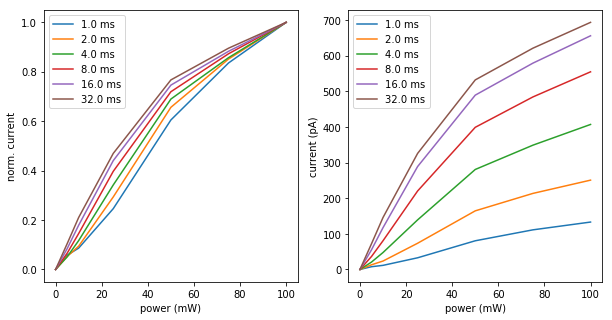

In [409]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
times = (20,40,80,160,320,640)
# plt.plot(intensity,Ipred[time])
for time in times:
    plt.plot(intensity,Imeas[time]/Imeas[time].max())
plt.legend([str(time/20)+' ms' for time in times])
plt.xlabel('power (mW)')
plt.ylabel('norm. current')
plt.subplot(1,2,2)
times = (20,40,80,160,320,640)
# plt.plot(intensity,Ipred[time])
for time in times:
    plt.plot(intensity,Imeas[time])
plt.legend([str(time/20)+' ms' for time in times])
plt.xlabel('power (mW)')
plt.ylabel('current (pA)')
plt.savefig('gtacr_intensity_v_current.pdf')

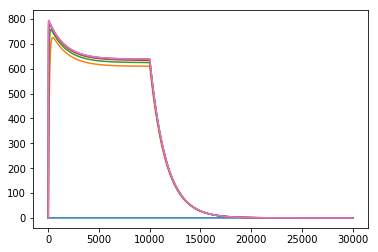

In [374]:
plt.figure()
plt.plot(Ipred_guess)

In [375]:
param_opt = sop.least_squares(off_by_function_compressed,param_guess,bounds=(0,np.inf))

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in multiply
  if sys.path[0] == '':
/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':


In [376]:
param_opt['x']

array([  1.54922610e+03,   1.44590074e-13,   1.88655741e-02,
         2.60829171e-02,   3.22702854e+03])

In [378]:
Imax = param_opt['x'][0]
koff = param_opt['x'][1]
kinact = param_opt['x'][2]
kreact = param_opt['x'][3]
intensity0 = param_opt['x'][4]
Ipred = Imax*model_C(koff,kinact,kreact,intensity0)

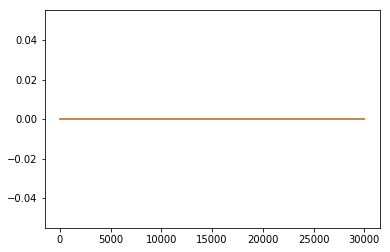

In [385]:
plt.figure()
k = 0
plt.plot(Ipred[:,k])
plt.plot(Imeas[:,k])

In [377]:
param_opt

 active_mask: array([ 0, -1,  0,  0,  0])
        cost: 79824753.695054889
         fun: array([  0.        ,   4.55854671,   2.96009544, ...,  10.13667923,
        10.88656962,   9.59070544])
        grad: array([  1.90443129e-03,   6.25655421e+07,  -2.68283535e+05,
         1.86465205e+04,   3.09878947e-01])
         jac: array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       ..., 
       [ -2.15453387e-09,   3.42583656e-03,   3.46946716e-03,
         -3.15904617e-05,   4.06349734e-10],
       [ -2.46232442e-09,   3.95500660e-03,   4.01377678e-03,
         -4.24385071e-05,   4.06349734e-10],
       [ -2.69316733e-09,   4.28593159e-03,   4.35543060e-03,
         -5.01871109e-05,   3.69408849e-10]])
     message: '`ft

In [89]:
param_actual

(100, 0.01, 0.01, 0.001, 40)

In [83]:
param_actual = (Imax,koff,kinact,kreact,intensity0)

In [159]:
for i,time in enumerate(t[:-1]):
    # conductance based membrane voltage model, defined relative to 
    V[i+1] = V[i] + dt*gmax*Copen[i]*(Ec-V[i]) + dt*gL*(Vrest-V[i])

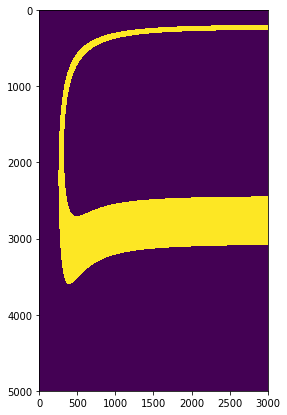

In [160]:
plt.figure(figsize=(10,7))
thresh = -50 # look for time until cell depolarizes to this voltage, in mV
plt.imshow(np.abs(V-thresh)<2)


In [161]:
def lorentzian(z,zR=1):
    return 1/(1+(z/zR)**2)

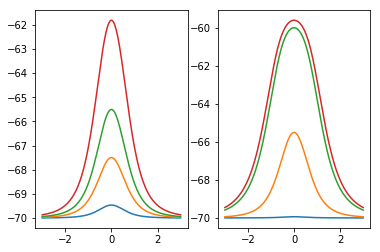

In [162]:
# assuming a Lorentzian point spread function, plot depolarization vs. z (in units of FWHM/2)
# for various choice of dwell time and light intensity

plt.figure()
plt.subplot(1,2,1)
# t = 100
z = np.linspace(-3,3,1000)
for time in (30,70,100,150):
    vals = np.interp(lorentzian(z),intensity,V[time,:])
    plt.plot(z,vals)

plt.subplot(1,2,2)
time = 100
z = np.linspace(-3,3,1000)
for i in (0.1,1,2.6,3):
    vals = np.interp(i*lorentzian(z),intensity,V[time,:])
    plt.plot(z,vals)

In [163]:
def compute_fwhm(thisintensityind,thistimeind):
    Vmax = V[thistimeind,thisintensityind] # depolarization at focus
    intensityhalfmax = np.interp(Vrest+(Vmax-Vrest)/2,V[thistimeind,:],intensity) # intensity corresponding to half maximal depolarization
    zhalfmax = np.interp(intensityhalfmax/intensity[thisintensityind],lorentzian(z[z>0])[::-1],z[z>0][::-1])
    return zhalfmax

In [164]:
np.interp(0.5,lorentzian(z[z>0])[::-1],z[z>0][::-1])

1.0

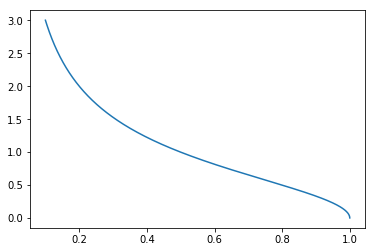

In [165]:
plt.figure()
plt.plot(lorentzian(z[z>0]),z[z>0])

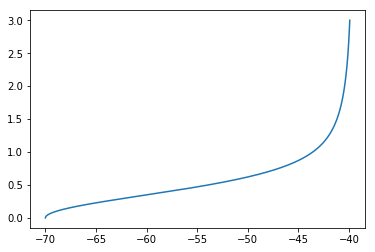

In [166]:
plt.figure()
plt.plot(V[500,:],intensity)

In [167]:
fwhm = compute_fwhm(100,100)

In [168]:
tlim = t.size
ilim = intensity.size
S = np.zeros((ilim,tlim))
for i in range(ilim):
    for j in range(tlim):
        S[i,j] = compute_fwhm(i,j)

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


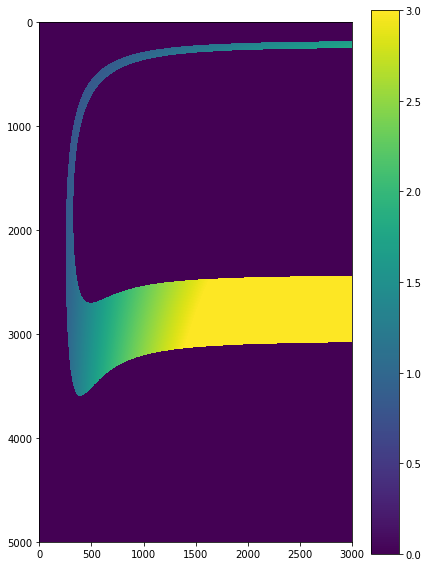

In [169]:
plt.figure(figsize=(7,10))
# plt.subplot(1,2,1)
plt.imshow((S.T)*(np.abs(V-thresh)<2))
plt.colorbar()
# plt.subplot(1,2,2)
# plt.imshow(V)
# plt.colorbar()

In [189]:
spreadbyintensity = np.zeros(intensity.size)
towait = np.zeros(intensity.size)
for i in range(intensity.size):
    try:
        towait[i] = np.interp(thresh,V[:,i][:np.argmax(V[:,i])],t[:np.argmax(V[:,i])])
    except:
        towait[i] = np.nan
    spreadbyintensity[i] = np.interp(towait[i],t,S[i,:])

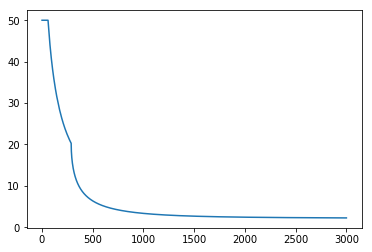

In [192]:
plt.plot(towait)

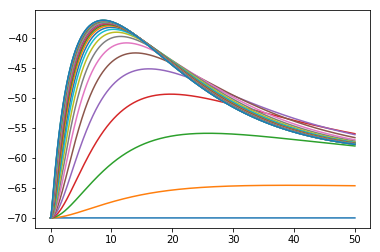

In [201]:
plt.figure()
i = 100
# plt.plot(V[:,i][:np.argmax(V[:,i])])
plt.plot(t,V[:,::100])

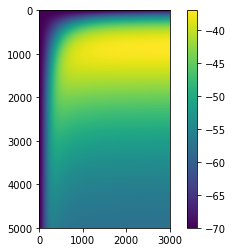

In [178]:
plt.figure()
plt.imshow(V)
plt.colorbar()

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


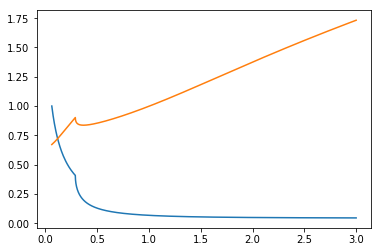

In [196]:
plt.figure()
# plt.plot(towait/towait.max())
gd = towait<np.nanmax(towait)
plt.plot(intensity[gd],towait[gd]/np.nanmax(towait[gd]))
plt.plot(intensity[gd],spreadbyintensity[gd])

In [194]:
gd = towait<np.nanmax(towait)
gd

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


array([False, False, False, ...,  True,  True,  True], dtype=bool)

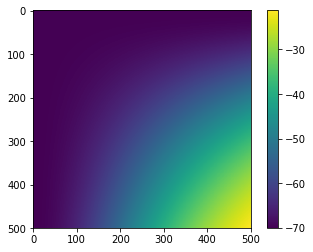

In [95]:
plt.figure()
plt.imshow(V[:500,:500])
plt.colorbar()

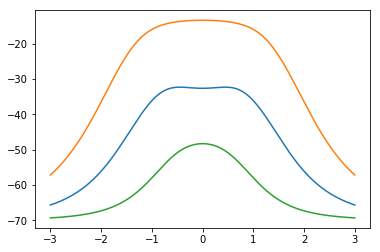

In [56]:


Vtgt = 20

stoptime = -1
peakintensity = np.argmin(np.abs(V[stoptime]-Vtgt))
vals = np.interp(1.2*intensity[peakintensity]*lorentzian(z),intensity,V[stoptime,:])
plt.plot(z,vals)

stoptime = 250
peakintensity = np.argmin(np.abs(V[stoptime]-Vtgt))
vals = np.interp(intensity[peakintensity]*lorentzian(z),intensity,V[stoptime,:])
plt.plot(z,vals)

stoptime = 50
peakintensity = np.argmin(np.abs(V[stoptime]-Vtgt))
vals = np.interp(intensity[peakintensity]*lorentzian(z),intensity,V[stoptime,:])
plt.plot(z,vals)

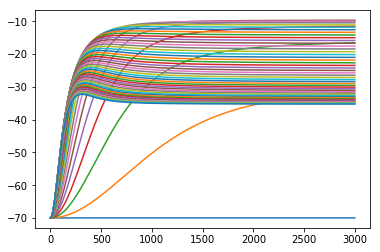

In [57]:
plt.figure()
# at various times, plot the intensity vs. depolarization curve
plt.plot(V[::100,:].T)

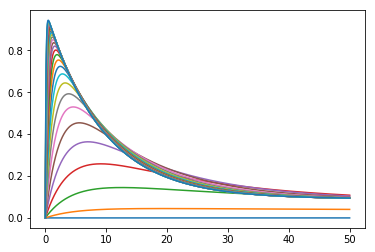

In [61]:
plt.figure()
# at various intensities, plot the time vs. depolarization curve
plt.plot(t,Copen[:,::100])

need to figure out the combination of intensity and waiting time that maximizes the squareness of the intensity dependence while still ensuring a spike at the desired location. Is it slow and low intensity, or fast and high intensity?

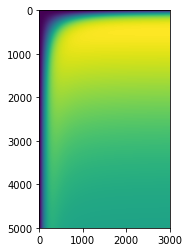

In [59]:
plt.figure()
plt.imshow(V)

In [60]:
t.shape

(5001,)